In [1]:
import json

import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline

# Get advanced (ORPM/DRPM) stats from ESPN

In [2]:
url_base = 'http://www.espn.com/nba/statistics/rpm/_/'
urls = [url_base]
for i in range(1, 12):
    urls.append(url_base + 'page/' + str(i))

In [ ]:
years = ['2023', '2022', '2021', '2020']
espn_dfs = {}
for year in years:
    url_base = 'http://www.espn.com/nba/statistics/rpm/_/year/' + str(year) + '/'
    urls = [
        url_base + 'page/' + str(i)
        for i in range(1, 12)
    ]
    dfs = []
    for url in urls:
        # print(url)
        df = pd.read_html(url)[0]
        df.columns = df.iloc[0].apply(lambda x: x.lower())
        df = df.iloc[1:]
        df = df[df.columns[1:]]
        df['position'] = df.name.apply(lambda x: x.split(',')[1][1:])
        df.name = df.name.apply(lambda x: x.split(',')[0])
        dfs.append(df)
    espn_df = pd.concat(dfs)
    espn_dfs[year] = espn_df

In [318]:
# Number of players in 2023
espn_dfs['2023'].name.nunique()

440

# Get stats for minutes played by each player against all other players

In [6]:
teams_response = requests.get("https://api.pbpstats.com/get-teams/nba")
teams = teams_response.json()
team_names = [team['text'] for team in teams['teams']]

In [ ]:
players_url = "https://api.pbpstats.com/get-team-players-for-season"
players_teams = []
year = "2023"
def translate_year(year):
    return str(int(year)-1) + '-' + str(int(year) % 100)

for year in ['2021', '2022', '2023']:
    for team in [team['id'] for team in teams['teams']]:
        players_params = {
            "Season": translate_year(year),
            "SeasonType": "Regular Season",
            "TeamId": team
        }
        players_response = requests.get(players_url, params=players_params)
        players = players_response.json()['players']
        players_teams += [
            {'player': player, 'name': players[player], 'team': team, "year": year} 
            for player in players]

In [64]:
players_teams_df = pd.DataFrame(players_teams)
players_teams_df.tail()

,player,name,team,year
1896,1630264,Anthony Gill,1610612764,2023
1897,1630557,Corey Kispert,1610612764,2023
1898,1630648,Jordan Schakel,1610612764,2023
1899,1630692,Jordan Goodwin,1610612764,2023
1900,1631098,Johnny Davis,1610612764,2023


In [7]:
def get_team_name(team_name):
    if team_name == 'BKN':
        return 'BRK'
    elif team_name == 'CHA':
        return 'CHO'
    elif team_name == 'PHX':
        return 'PHO'
    else:
        return team_name

In [302]:
def get_team(player, year, by_name=False):
    if not by_name:
        return players_teams_df[
            (players_teams_df.player == player) & (players_teams_df.year == year)
        ].iloc[0]['team']
    else:
        return players_teams_df[
            (players_teams_df.name == player) & (players_teams_df.year == year)
        ].iloc[0]['team']

def get_team_by_id(team_id):
    matching_teams = [t for t in teams['teams'] if t['id'] == team_id]
    if len(matching_teams) > 0:
        return matching_teams[0]['text']
    else:
        return None

def get_opp_player_minutes(player, vs_team, season, offdef='Offense'):
    # Season like "2022-23"
    url = "https://api.pbpstats.com/get-possessions/nba"
    player_team = get_team(player, season)
    params = {
        "TeamId": vs_team,
        "Season": translate_year(season),
        "SeasonType": "Regular Season",
        "OffDef": offdef, # Offense or Defense
        "StartType": "All", # see below for possible values for StartType
        "Opponent": player_team,
        "OpponentExactly1OnFloor": player
    }
    response = requests.get(url, params=params)
    response_json = response.json()
    return pd.DataFrame(response_json["player_results"])
    # team_stats = response_json["team_results"]
    # possessions = pd.DataFrame(response_json["possessions"])

In [272]:
def name_search_player(name):
    return players_teams_df[players_teams_df.name.str.contains(name)].iloc[0]['player']

def name_search_team(team):
    return [t for t in teams['teams'] if t['text'] == team][0]['id']

def opp_drpm(minutes_df):
    total = (minutes_df.SecondsPlayed.fillna(0).values * minutes_df.drpm.astype('float').values).sum()
    return {'weighted_drpm': total, 'seconds': minutes_df.SecondsPlayed.fillna(0).values.sum()}

def opp_orpm(minutes_df):
    total = (minutes_df.SecondsPlayed.fillna(0).values * minutes_df.orpm.astype('float').values).sum()
    return {'weighted_orpm': total, 'seconds': minutes_df.SecondsPlayed.fillna(0).values.sum()}

In [ ]:
# Iterate through all players and all teams
team_ids = players_teams_df.team.unique()
year = '2023'
if 'player_opp_drpms' not in globals():
    player_opp_drpms = []
for player in players_teams_df[players_teams_df.year == year].name:
    existing = [p for p in player_opp_drpms if p['player'] == player]
    if len(existing) > 0 and existing[0]['']
        continue
    player_id = name_search_player(player)
    player_minutes_dfs = []
    drpms = []
    for team in team_ids:
        if team == get_team(player_id, '2023'):
            continue
        try:
            df = get_opp_player_minutes(player_id, team, year)
        except:
            import time
            time.sleep(0.2)
            df = get_opp_player_minutes(player_id, team, year)
        if len(df) == 0:
            continue
        player_minutes_dfs.append(df)
        minutes_df_merged = df.merge(espn_dfs['2023'], left_on='Name', right_on='name')
        drpms.append(opp_drpm(minutes_df_merged))
    player_opp_drpms.append({
        'player': player,
        'player_id': player_id,
        'player_minutes_dfs': player_minutes_dfs,
        'avg_opp_drpm': sum([d['weighted_drpm'] for d in drpms]) / sum(
            [d['seconds'] for d in drpms]) if len(drpms) > 0 else None
    })
    print(player_opp_drpms[-1]['player'], player_opp_drpms[-1]['avg_opp_drpm'])

In [ ]:
for player in player_opp_drpms:
    if len(player['player_minutes_dfs']) > 0 and len(player['player_minutes_dfs']) < 55:
        player['player_minutes_dfs'] = pd.concat(
            player['player_minutes_dfs']
        ).merge(
            espn_dfs['2023'], left_on='Name', right_on='name')

In [273]:
for player in player_opp_drpms:
    if len(player['player_minutes_dfs']) > 0:
        avg_opp_orpm = opp_orpm(player['player_minutes_dfs'])
        player['avg_opp_orpm'] = avg_opp_orpm['weighted_orpm'] / avg_opp_orpm['seconds']
        avg_opp_drpm = opp_drpm(player['player_minutes_dfs'])
        player['avg_opp_drpm'] = avg_opp_drpm['weighted_drpm'] / avg_opp_drpm['seconds']
    else:
        player['avg_opp_orpm'] = None


In [335]:
player_opp_drpms = [player for player in player_opp_drpms if len(player['player_minutes_dfs']) > 0]

In [421]:
[player['player_minutes_dfs'] for player in player_opp_drpms if 'Zion' in player['player']][0].sort_values(
    'SecondsPlayed').iloc[-20:][['name', 'position']]

,name,position
141,Tobias Harris,PF
147,P.J. Tucker,PF
148,James Harden,SG
158,Damion Lee,SG
59,Jonathan Kuminga,PF
178,Tre Jones,PG
204,Walker Kessler,C
175,Keldon Johnson,SF
58,Jordan Poole,SG
177,Devin Vassell,SG


In [345]:
player_opp_drpms[0].keys()

dict_keys(['player', 'player_id', 'player_minutes_dfs', 'avg_opp_drpm', 'avg_opp_orpm'])

In [403]:
orpm_drpm_df = pd.DataFrame({
    'player': [player['player'] for player in player_opp_drpms],
    'avg_opp_orpm': [player['avg_opp_orpm'] for player in player_opp_drpms],
    'avg_opp_drpm': [player['avg_opp_drpm'] for player in player_opp_drpms],
    'team': [get_team_by_id(get_team(player['player'], '2023', by_name=True)) for player in player_opp_drpms],
}).dropna(subset=['avg_opp_orpm']).merge(espn_dfs['2023'][[
    'name', 'orpm', 'drpm', 'position', 'gp', 'mpg']], left_on='player', right_on='name')
for c in 'orpm', 'drpm', 'gp', 'mpg':
    orpm_drpm_df[c] = orpm_drpm_df[c].astype('float')
orpm_drpm_df['minutes'] = orpm_drpm_df['gp'] * orpm_drpm_df['mpg']
orpm_drpm_df = orpm_drpm_df[orpm_drpm_df.minutes > 300]

# Analysis

In [348]:
orpm_drpm_df.head()

,player,avg_opp_orpm,avg_opp_drpm,team,name,orpm,drpm,position,gp,mpg
0,Justin Holiday,-0.067708,-0.534254,ATL,Justin Holiday,-1.58,-3.44,SF,27,15.0
1,Clint Capela,-0.021441,0.845204,ATL,Clint Capela,-1.27,3.84,C,34,27.1
2,Bogdan Bogdanovic,0.163781,-0.095768,ATL,Bogdan Bogdanovic,1.09,-2.27,SG,25,30.7
3,Frank Kaminsky,-0.171438,-0.715241,ATL,Frank Kaminsky,0.93,-2.34,PF,24,7.0
4,Dejounte Murray,-0.009885,0.620845,ATL,Dejounte Murray,-0.29,3.40,SG,45,36.6


In [358]:
# Players with highest opposing DRPM
orpm_drpm_df.sort_values('avg_opp_drpm').iloc[-10:]

,player,avg_opp_orpm,avg_opp_drpm,team,name,orpm,drpm,position,gp,mpg,minutes
172,Marcus Morris Sr.,0.191363,0.846881,LAC,Marcus Morris Sr.,-1.94,4.56,SF,46.0,28.9,1329.4
404,O.G. Anunoby,0.053317,0.853820,TOR,O.G. Anunoby,-1.96,3.95,SF,45.0,35.8,1611.0
57,Nikola Vucevic,0.136335,0.870881,CHI,Nikola Vucevic,0.26,3.10,C,49.0,33.9,1661.1
353,Jusuf Nurkic,0.121002,0.890980,POR,Jusuf Nurkic,-1.21,5.32,C,43.0,27.9,1199.7
31,Marcus Smart,0.065907,0.900937,BOS,Marcus Smart,0.11,1.26,PG,41.0,32.5,1332.5
319,P.J. Tucker,0.183040,0.912638,PHI,P.J. Tucker,-7.50,3.67,PF,46.0,26.4,1214.4
160,Tyrese Haliburton,0.034268,0.957469,IND,Tyrese Haliburton,4.46,1.17,PG,40.0,33.4,1336.0
155,Myles Turner,0.052436,0.959811,IND,Myles Turner,0.49,4.55,C,42.0,30.0,1260.0
29,Al Horford,0.082431,0.967930,BOS,Al Horford,-1.93,4.13,C,40.0,30.9,1236.0
42,Mason Plumlee,0.056304,1.126215,CHA,Mason Plumlee,0.16,2.72,C,50.0,28.2,1410.0


In [359]:
# Players with highest opposing ORPM
orpm_drpm_df.sort_values('avg_opp_orpm').iloc[-10:]

,player,avg_opp_orpm,avg_opp_drpm,team,name,orpm,drpm,position,gp,mpg,minutes
393,Devin Vassell,0.233812,0.232962,SAS,Devin Vassell,1.39,-1.77,SG,29.0,31.3,907.7
191,Troy Brown Jr.,0.235101,0.367977,LAL,Troy Brown Jr.,-2.39,1.20,SF,44.0,23.8,1047.2
379,Jeremy Sochan,0.245049,0.599335,SAS,Jeremy Sochan,-2.36,1.24,F,43.0,26.2,1126.6
309,Wendell Carter Jr.,0.253807,0.625463,ORL,Wendell Carter Jr.,0.47,0.75,C,31.0,30.3,939.3
121,Cade Cunningham,0.259053,0.456098,DET,Cade Cunningham,0.91,-1.88,PG,12.0,33.3,399.6
192,Lonnie Walker IV,0.259545,0.675052,LAL,Lonnie Walker IV,-0.38,-0.82,G,33.0,29.4,970.2
306,Markelle Fultz,0.265797,0.840594,ORL,Markelle Fultz,-1.24,0.12,PG,29.0,27.9,809.1
184,Russell Westbrook,0.304769,0.202851,LAL,Russell Westbrook,2.74,-5.42,PG,47.0,28.6,1344.2
186,Anthony Davis,0.324831,0.599213,LAL,Anthony Davis,2.81,2.18,PF,27.0,33.2,896.4
183,LeBron James,0.327397,0.722197,LAL,LeBron James,5.00,2.73,SF,40.0,36.3,1452.0


In [367]:
# Players on the Pelicans
# Bench players face worse opposing players, sensibly
orpm_drpm_df[orpm_drpm_df.team == 'NOP'].sort_values('avg_opp_orpm')

,player,avg_opp_orpm,avg_opp_drpm,team,name,orpm,drpm,position,gp,mpg,minutes
273,Dyson Daniels,-0.026917,0.111501,NOP,Dyson Daniels,-2.65,-0.25,G,39.0,19.9,776.1
264,Brandon Ingram,-0.019441,0.445226,NOP,Brandon Ingram,0.56,-0.82,SF,17.0,31.5,535.5
260,Jonas Valanciunas,0.005226,0.828483,NOP,Jonas Valanciunas,-0.79,3.29,C,50.0,24.8,1240.0
266,Zion Williamson,0.011757,0.421738,NOP,Zion Williamson,2.47,0.02,PF,29.0,33.0,957.0
272,Jose Alvarado,0.027814,0.051028,NOP,Jose Alvarado,0.64,-1.55,PG,49.0,22.0,1078.0
271,Trey Murphy III,0.033522,0.570896,NOP,Trey Murphy III,0.11,0.76,SG,47.0,29.0,1363.0
261,CJ McCollum,0.035161,0.694681,NOP,CJ McCollum,1.36,1.44,SG,45.0,35.2,1584.0
262,Willy Hernangomez,0.039004,-0.280454,NOP,Willy Hernangomez,0.59,-1.90,C,25.0,12.7,317.5
265,Devonte' Graham,0.064605,-0.318731,NOP,Devonte' Graham,0.67,-2.72,PG,50.0,15.3,765.0
269,Naji Marshall,0.073726,0.202381,NOP,Naji Marshall,-0.68,-0.73,SF,45.0,25.0,1125.0


In [422]:
orpm_drpm_df[orpm_drpm_df.team == 'MIL'].sort_values('avg_opp_orpm')

,player,avg_opp_orpm,avg_opp_drpm,team,name,orpm,drpm,position,gp,mpg,minutes
242,MarJon Beauchamp,-0.161980,0.041350,MIL,MarJon Beauchamp,-0.56,-2.09,G,33.0,15.3,504.9
232,George Hill,-0.034697,-0.176034,MIL,George Hill,0.06,-2.58,PG,34.0,19.6,666.4
236,Joe Ingles,-0.011341,0.061263,MIL,Joe Ingles,0.77,-4.53,SG,17.0,21.8,370.6
239,Grayson Allen,-0.007438,0.773332,MIL,Grayson Allen,-0.88,2.86,SG,45.0,27.4,1233.0
233,Jrue Holiday,-0.005062,0.647292,MIL,Jrue Holiday,2.59,-0.33,PG,38.0,32.8,1246.4
238,Pat Connaughton,-0.000663,0.431850,MIL,Pat Connaughton,-0.19,-0.78,SG,33.0,24.7,815.1
240,Jevon Carter,0.007154,0.463896,MIL,Jevon Carter,-2.21,-0.08,PG,49.0,23.4,1146.6
230,Brook Lopez,0.013913,0.650006,MIL,Brook Lopez,-0.27,4.31,C,48.0,30.4,1459.2
235,Giannis Antetokounmpo,0.018927,0.682890,MIL,Giannis Antetokounmpo,5.20,0.13,PF,38.0,33.4,1269.2
237,Bobby Portis,0.025039,0.288408,MIL,Bobby Portis,1.21,-2.02,F,47.0,26.8,1259.6


<AxesSubplot:xlabel='position'>

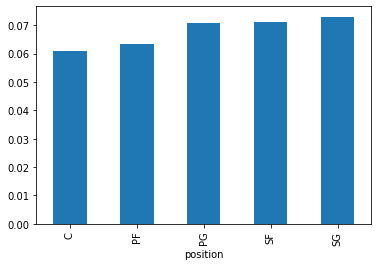

In [434]:
orpm_drpm_df[~orpm_drpm_df.position.isin(['G', 'F'])].groupby('position').avg_opp_orpm.mean().sort_values().plot.bar()

<AxesSubplot:xlabel='position'>

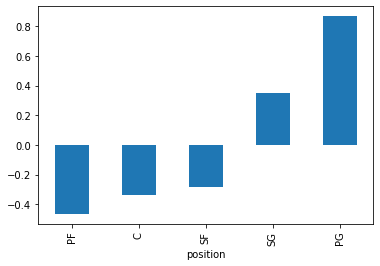

In [433]:
orpm_drpm_df[~orpm_drpm_df.position.isin(['G', 'F'])].groupby('position').orpm.mean().sort_values().plot.bar()

<AxesSubplot:xlabel='position'>

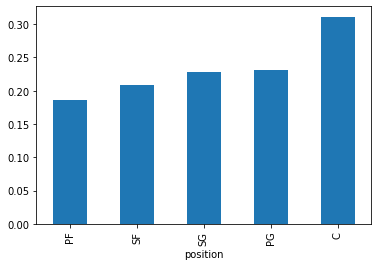

In [432]:
orpm_drpm_df[~orpm_drpm_df.position.isin(['G', 'F'])].groupby('position').avg_opp_drpm.mean().sort_values().plot.bar()

<AxesSubplot:xlabel='position'>

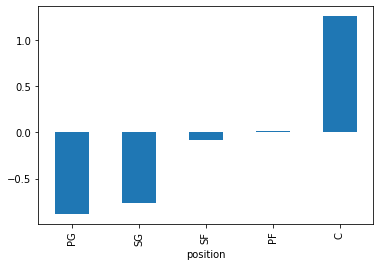

In [431]:
orpm_drpm_df[~orpm_drpm_df.position.isin(['G', 'F'])].groupby('position').drpm.mean().sort_values().plot.bar()

0.7044293992139203


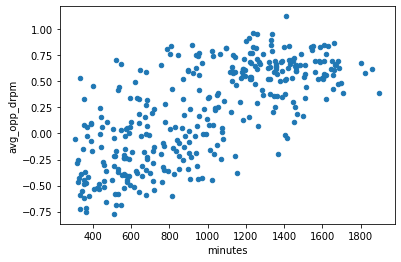

In [427]:
x, y = 'minutes', 'avg_opp_drpm'
print(orpm_drpm_df[[x, y]].corr().loc[x, y])
ax = orpm_drpm_df.plot.scatter(x, y)

# for _, row in orpm_drpm_df.iterrows():
#     ax.annotate(row['player'], (row[x], row[y]))

0.645339014755161


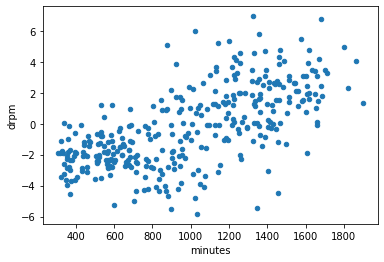

In [426]:
x, y = 'minutes', 'drpm'
print(orpm_drpm_df[[x, y]].corr().loc[x, y])
ax = orpm_drpm_df.plot.scatter(x, y)

0.20156319715893073


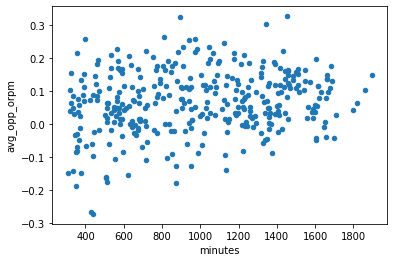

In [429]:
x, y = 'minutes', 'avg_opp_orpm'
print(orpm_drpm_df[[x, y]].corr().loc[x, y])
ax = orpm_drpm_df.plot.scatter(x, y)

0.14400498140708118


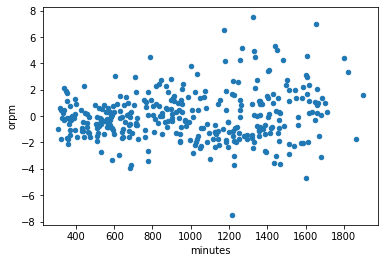

In [428]:
x, y = 'minutes', 'orpm'
print(orpm_drpm_df[[x, y]].corr().loc[x, y])
ax = orpm_drpm_df.plot.scatter(x, y)

                  orpm  avg_opp_drpm
orpm          1.000000      0.025796
avg_opp_drpm  0.025796      1.000000


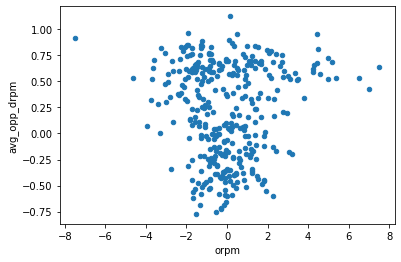

In [408]:
x, y = 'orpm', 'avg_opp_drpm'
print(orpm_drpm_df[[x, y]].corr())
ax = orpm_drpm_df.plot.scatter(x, y)

                  orpm  avg_opp_orpm
orpm          1.000000      0.075273
avg_opp_orpm  0.075273      1.000000


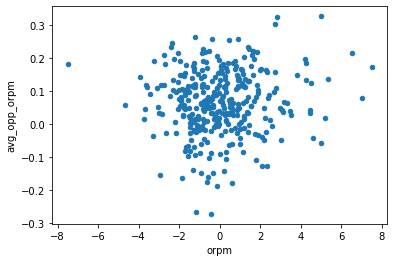

In [409]:
x, y = 'orpm', 'avg_opp_orpm'
print(orpm_drpm_df[[x, y]].corr())
ax = orpm_drpm_df.plot.scatter(x, y)

                  drpm  avg_opp_drpm
drpm          1.000000      0.738711
avg_opp_drpm  0.738711      1.000000


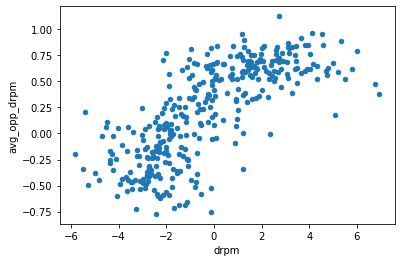

In [410]:
x, y = 'drpm', 'avg_opp_drpm'
print(orpm_drpm_df[[x, y]].corr())
ax = orpm_drpm_df.plot.scatter(x, y)

                  drpm  avg_opp_orpm
drpm          1.000000      0.096045
avg_opp_orpm  0.096045      1.000000


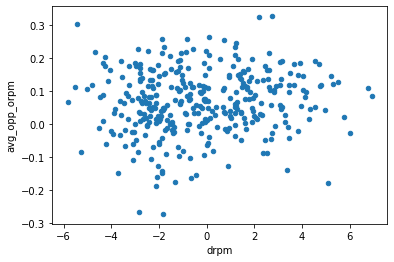

In [411]:
x, y = 'drpm', 'avg_opp_orpm'
print(orpm_drpm_df[[x, y]].corr())
ax = orpm_drpm_df.plot.scatter(x, y)